In [1]:
from nn_globals import *

from nn_encode import nlayers, nvariables

from nn_data import (muon_data_split, pileup_data_split, mix_training_inputs)

from nn_models import (create_model_bn2, lr_decay, modelbestcheck, modelbestcheck_weights)

from nn_training import train_model

from nn_pruning import prune_model

%matplotlib inline

[INFO    ] Using cmssw CMSSW_10_4_0
[INFO    ] Using numpy 1.15.1
[INFO    ] Using tensorflow 1.6.0
Using TensorFlow backend.
[INFO    ] Using keras 2.1.4
[INFO    ] .. list devices: [_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456)]
[INFO    ] Using scipy 1.1.0
[INFO    ] Using sklearn 0.19.1
[INFO    ] Using matplotlib 2.2.3


In [2]:
# Training parameters

do_training = True

run2_input = False

omtf_input = False

displ_input = True

model_name = 'model'

epochs = 300

batch_size = 4096

tile = 6

# ______________________________________________________________________________
if omtf_input:
  from nn_encode_omtf import nlayers, nvariables
  from nn_data_omtf import (muon_data_split, pileup_data_split, mix_training_inputs)
  
  model_name = 'model_omtf'
  
  epochs = 450
  
  tile = 11

# ______________________________________________________________________________
if displ_input:
  model_name = 'model_displ'
  
  epochs = 300

### Import data

In [3]:
infile_muon_no_displ = '../test7/histos_tba_no_displ.24.npz'

infile_muon_displ = '../test7/histos_tba_displ.24.npz'

nentries = 1520000

In [4]:
from sklearn.model_selection import train_test_split

from nn_encode import Encoder

def muon_data(filename, reg_pt_scale=1.0, reg_dxy_scale=1.0, correct_for_eta=False):
  try:
    logger.info('Loading muon data from {0} ...'.format(filename))
    loaded = np.load(filename)
    the_variables = loaded['variables']
    the_parameters = loaded['parameters']
    the_variables = the_variables[:nentries]
    the_parameters = the_parameters[:nentries]
    logger.info('Loaded the variables with shape {0}'.format(the_variables.shape))
    logger.info('Loaded the parameters with shape {0}'.format(the_parameters.shape))
  except:
    logger.error('Failed to load data from file: {0}'.format(filename))

  assert(the_variables.shape[0] == the_parameters.shape[0])

  encoder = Encoder(the_variables, the_parameters, reg_pt_scale=reg_pt_scale, reg_dxy_scale=reg_dxy_scale)
  if correct_for_eta:
    x, y, dxy, dz, w, x_mask, x_road = encoder.get_x(), encoder.get_y_corrected_for_eta(), encoder.get_dxy(), encoder.get_dz(), encoder.get_w(), encoder.get_x_mask(), encoder.get_x_road()
  else:
    x, y, dxy, dz, w, x_mask, x_road = encoder.get_x(), encoder.get_y(), encoder.get_dxy(), encoder.get_dz(), encoder.get_w(), encoder.get_x_mask(), encoder.get_x_road()
  logger.info('Loaded the encoded variables with shape {0}'.format(x.shape))
  logger.info('Loaded the encoded parameters with shape {0}'.format(y.shape))
  assert(np.isfinite(x).all())
  return x, y, dxy, dz, w, x_mask, x_road


def muon_data_split(filename, reg_pt_scale=1.0, reg_dxy_scale=1.0, test_size=0.5, correct_for_eta=False):
  x, y, dxy, dz, w, x_mask, x_road = muon_data(filename, reg_pt_scale=reg_pt_scale, reg_dxy_scale=reg_dxy_scale, correct_for_eta=correct_for_eta)

  # Split dataset in training and testing
  x_train, x_test, y_train, y_test, dxy_train, dxy_test, dz_train, dz_test, w_train, w_test, x_mask_train, x_mask_test, x_road_train, x_road_test = train_test_split(x, y, dxy, dz, w, x_mask, x_road, test_size=test_size)
  logger.info('Loaded # of training and testing events: {0}'.format((x_train.shape[0], x_test.shape[0])))

  # Check for cases where the number of events in the last batch could be too few
  validation_split = 0.1
  train_num_samples = int(x_train.shape[0] * (1.0-validation_split))
  val_num_samples = x_train.shape[0] - train_num_samples
  batch_size = 128
  if (train_num_samples%batch_size) < 100:
    logger.warning('The last batch for training could be too few! ({0}%{1})={2}. Please change test_size.'.format(train_num_samples, batch_size, train_num_samples%batch_size))
    logger.warning('Try this formula: int(int({0}*{1})*{2}) % 128'.format(x.shape[0], 1.0-test_size, 1.0-validation_split))
  train_num_samples = int(x_train.shape[0] * 2 * (1.0-validation_split))
  val_num_samples = x_train.shape[0] - train_num_samples
  batch_size = 128
  if (train_num_samples%batch_size) < 100:
    logger.warning('The last batch for training after mixing could be too few! ({0}%{1})={2}. Please change test_size.'.format(train_num_samples, batch_size, train_num_samples%batch_size))
    logger.warning('Try this formula: int(int({0}*{1})*2*{2}) % 128'.format(x.shape[0], 1.0-test_size, 1.0-validation_split))
  return x_train, x_test, y_train, y_test, dxy_train, dxy_test, dz_train, dz_test, w_train, w_test, x_mask_train, x_mask_test, x_road_train, x_road_test

In [5]:
# Import muon data
# 'x' is the array of input variables, 'y' is the q/pT
x_train, x_test, y_train, y_test, dxy_train, dxy_test, dz_train, dz_test, w_train, w_test, x_mask_train, x_mask_test, x_road_train, x_road_test = \
      muon_data_split(infile_muon_no_displ, reg_pt_scale=reg_pt_scale, reg_dxy_scale=reg_dxy_scale, test_size=0.315)

[INFO    ] Loading muon data from ../test7/histos_tba_no_displ.24.npz ...
[INFO    ] Loaded the variables with shape (1520000, 179)
[INFO    ] Loaded the parameters with shape (1520000, 6)
[INFO    ] Loaded the encoded variables with shape (1520000, 36)
[INFO    ] Loaded the encoded parameters with shape (1520000,)
[INFO    ] Loaded # of training and testing events: (1041200, 478800)


In [6]:
# Import muon data
# 'x' is the array of input variables, 'y' is the q/pT
x_train_displ, x_test_displ, y_train_displ, y_test_displ, dxy_train_displ, dxy_test_displ, dz_train_displ, dz_test_displ, w_train_displ, w_test_displ, x_mask_train_displ, x_mask_test_displ, x_road_train_displ, x_road_test_displ = \
      muon_data_split(infile_muon_displ, reg_pt_scale=reg_pt_scale, reg_dxy_scale=reg_dxy_scale, test_size=0.315)

[INFO    ] Loading muon data from ../test7/histos_tba_displ.24.npz ...
[INFO    ] Loaded the variables with shape (1520000, 179)
[INFO    ] Loaded the parameters with shape (1520000, 6)
[INFO    ] Loaded the encoded variables with shape (1520000, 36)
[INFO    ] Loaded the encoded parameters with shape (1520000,)
[INFO    ] Loaded # of training and testing events: (1041200, 478800)


### Training (Part I)

Try different cases:
- (a) Train with prompt muons, apply to prompt muons
- (b) Train with displaced muons, apply to displaced muons
- (c) Train with displaced muons, apply to prompt muons
- (d) Train with prompt muons, apply to displaced muons

In [7]:
from nn_models import K, Sequential, Dense, BatchNormalization, Activation, \
                      regularizers, optimizers, huber_loss, ModelCheckpoint

def NewTanh(x):
  #return K.tanh(x)
  return 1.7159047 * K.tanh(x * 2./3.)
  #return K.clip(x, -1., 1.)

def create_model_sequential_bn2(nvariables, lr=0.001, clipnorm=10., nodes1=64, nodes2=32, nodes3=16, nodes4=0, nodes5=0, outnodes=1,
                                l1_reg=0.0, l2_reg=0.0, use_bn=True, use_dropout=False):
  # Adding 1 BN layer right after the input layer
  regularizer = regularizers.L1L2(l1=l1_reg, l2=l2_reg)

  model = Sequential()
  if use_bn: model.add(BatchNormalization(input_shape=(nvariables,), epsilon=1e-4, momentum=0.9))

  model.add(Dense(nodes1, kernel_initializer='glorot_uniform', kernel_regularizer=regularizer, use_bias=False))
  if use_bn: model.add(BatchNormalization(epsilon=1e-4, momentum=0.9))
  model.add(Activation('tanh'))
  if nodes2:
    model.add(Dense(nodes2, kernel_initializer='glorot_uniform', kernel_regularizer=regularizer, use_bias=False))
    if use_bn: model.add(BatchNormalization(epsilon=1e-4, momentum=0.9))
    model.add(Activation('tanh'))
    if nodes3:
      model.add(Dense(nodes3, kernel_initializer='glorot_uniform', kernel_regularizer=regularizer, use_bias=False))
      if use_bn: model.add(BatchNormalization(epsilon=1e-4, momentum=0.9))
      model.add(Activation('tanh'))
      if nodes4:
        model.add(Dense(nodes4, kernel_initializer='glorot_uniform', kernel_regularizer=regularizer, use_bias=False))
        if use_bn: model.add(BatchNormalization(epsilon=1e-4, momentum=0.9))
        model.add(Activation('tanh'))
        if nodes5:
          model.add(Dense(nodes5, kernel_initializer='glorot_uniform', kernel_regularizer=regularizer, use_bias=False))
          if use_bn: model.add(BatchNormalization(epsilon=1e-4, momentum=0.9))
          model.add(Activation('tanh'))

  # Output node
  model.add(Dense(outnodes, activation='linear', kernel_initializer='glorot_uniform'))

  # Set loss and optimizers
  adam = optimizers.Adam(lr=lr, clipnorm=clipnorm)
  model.compile(optimizer=adam, loss=huber_loss, metrics=['acc'])
  #model.compile(optimizer=adam, loss=unmasked_huber_loss, metrics=['acc'])
  model.summary()
  return model

In [8]:
logger.info('Using reg_pt_scale: {0}'.format(reg_pt_scale))
logger.info('Using reg_dxy_scale: {0}'.format(reg_dxy_scale))

[INFO    ] Using reg_pt_scale: 100.0
[INFO    ] Using reg_dxy_scale: 0.4


In [9]:
model = create_model_sequential_bn2(nvariables=nvariables, lr=learning_rate, clipnorm=gradient_clip_norm, l1_reg=l1_reg, l2_reg=l2_reg,
                          nodes1=50, nodes2=40, nodes3=30, nodes4=20)

modelbestcheck = ModelCheckpoint(filepath='model_bchk.h5', monitor='val_loss', verbose=0, save_best_only=True)
modelbestcheck_weights = ModelCheckpoint(filepath='model_bchk_weights.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 36)                144       
_________________________________________________________________
dense_1 (Dense)              (None, 50)                1800      
_________________________________________________________________
batch_normalization_2 (Batch (None, 50)                200       
_________________________________________________________________
activation_1 (Activation)    (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 40)                2000      
_________________________________________________________________
batch_normalization_3 (Batch (None, 40)                160       
_________________________________________________________________
activation_2 (Activation)    (None, 40)                0         
__________

In [10]:
logger.info('Begin training ...')
history = model.fit(x_train, y_train,
                    epochs=epochs, batch_size=batch_size,
                    callbacks=[lr_decay,modelbestcheck,modelbestcheck_weights], validation_split=0.1, verbose=0)
logger.info('Done training.')
logger.info('Epoch {0}/{0} - loss: {1} - val_loss: {2}'.format(
    len(history.history['loss']), history.history['loss'][-1], history.history['val_loss'][-1]))

model.load_weights('model_bchk_weights.h5')

[INFO    ] Begin training ...
[INFO    ] Done training.
[INFO    ] Epoch 300/300 - loss: 3.07796170269 - val_loss: 2.99417129876


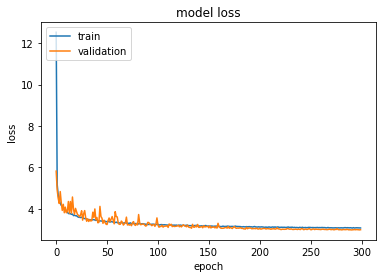

In [11]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [12]:
model_displ = create_model_sequential_bn2(nvariables=nvariables, lr=learning_rate, clipnorm=gradient_clip_norm, l1_reg=l1_reg, l2_reg=l2_reg,
                          nodes1=50, nodes2=40, nodes3=30, nodes4=20)

modelbestcheck = ModelCheckpoint(filepath='model_bchk.h5', monitor='val_loss', verbose=0, save_best_only=True)
modelbestcheck_weights = ModelCheckpoint(filepath='model_bchk_weights.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_6 (Batch (None, 36)                144       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1800      
_________________________________________________________________
batch_normalization_7 (Batch (None, 50)                200       
_________________________________________________________________
activation_5 (Activation)    (None, 50)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 40)                2000      
_________________________________________________________________
batch_normalization_8 (Batch (None, 40)                160       
_________________________________________________________________
activation_6 (Activation)    (None, 40)                0         
__________

In [13]:
logger.info('Begin training ...')
history = model_displ.fit(x_train_displ, y_train_displ,
                    epochs=epochs, batch_size=batch_size,
                    callbacks=[lr_decay,modelbestcheck,modelbestcheck_weights], validation_split=0.1, verbose=0)
logger.info('Done training.')
logger.info('Epoch {0}/{0} - loss: {1} - val_loss: {2}'.format(
    len(history.history['loss']), history.history['loss'][-1], history.history['val_loss'][-1]))

model_displ.load_weights('model_bchk_weights.h5')

[INFO    ] Begin training ...
[INFO    ] Done training.
[INFO    ] Epoch 300/300 - loss: 6.19021856436 - val_loss: 6.09902765686


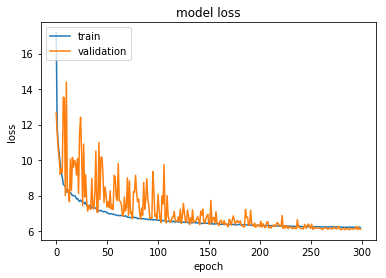

In [14]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [15]:
# Setup matplotlib
plt.style.use('tdrstyle.mplstyle')

from nn_plotting import (gaus, fit_gaus, np_printoptions, \
                         find_efficiency_errors)

eps = 1e-7
my_cmap = plt.cm.viridis
my_cmap.set_under('w',1)
my_palette = ("#377eb8", "#e41a1c", "#984ea3", "#ff7f00", "#4daf4a")

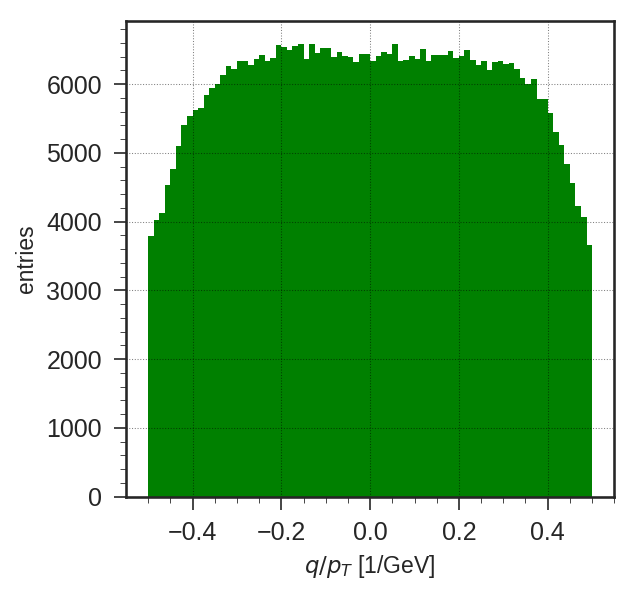

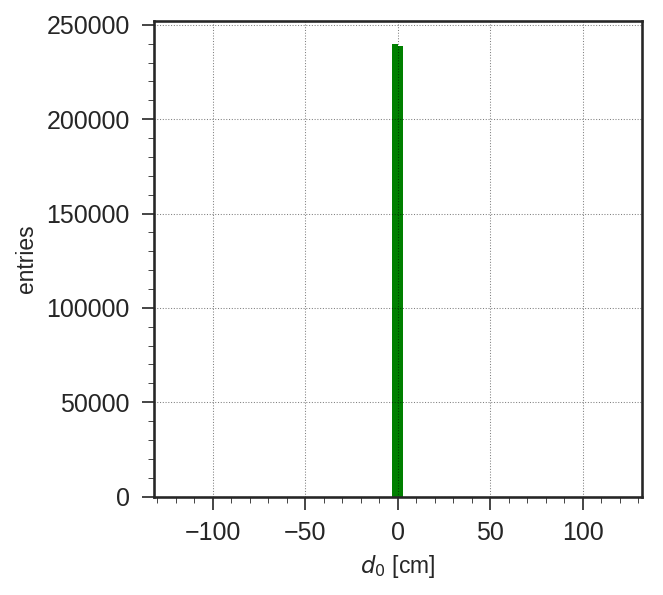

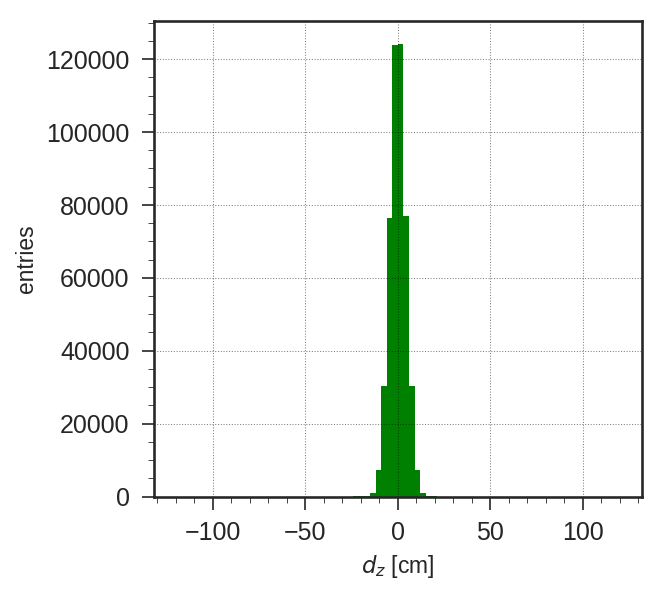

In [16]:
# Plot q/pT, d0, dz - no_displ

plt.figure()
plt.hist(y_test/reg_pt_scale, bins=80, range=(-0.5,0.5), color='g')
plt.xlabel(r'$q/p_{T}$ [1/GeV]', fontsize=11)
plt.ylabel(r'entries', fontsize=11)

plt.figure()
plt.hist(dxy_test/reg_dxy_scale, bins=80, range=(-120,120), color='g')
#plt.xlabel(r'$d_{xy}$ [cm]', fontsize=11)
plt.xlabel(r'$d_{0}$ [cm]', fontsize=11)
plt.ylabel(r'entries', fontsize=11)

plt.figure()
plt.hist(dz_test, bins=80, range=(-120,120), color='g')
plt.xlabel(r'$d_{z}$ [cm]', fontsize=11)
plt.ylabel(r'entries', fontsize=11)

plt.show()

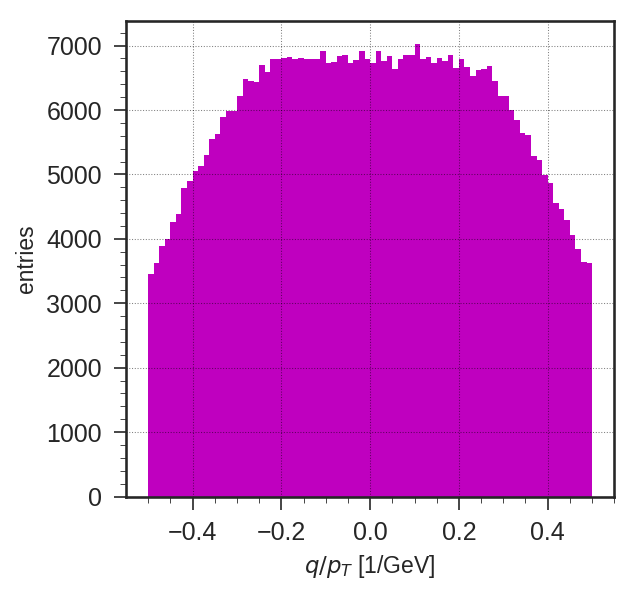

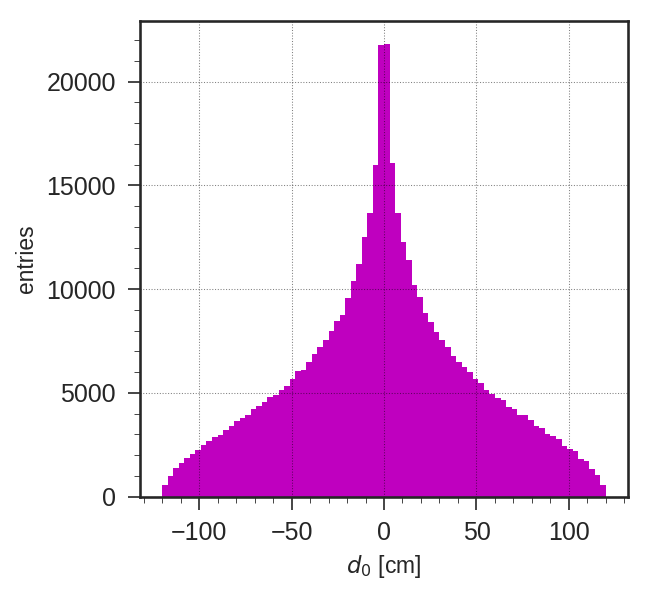

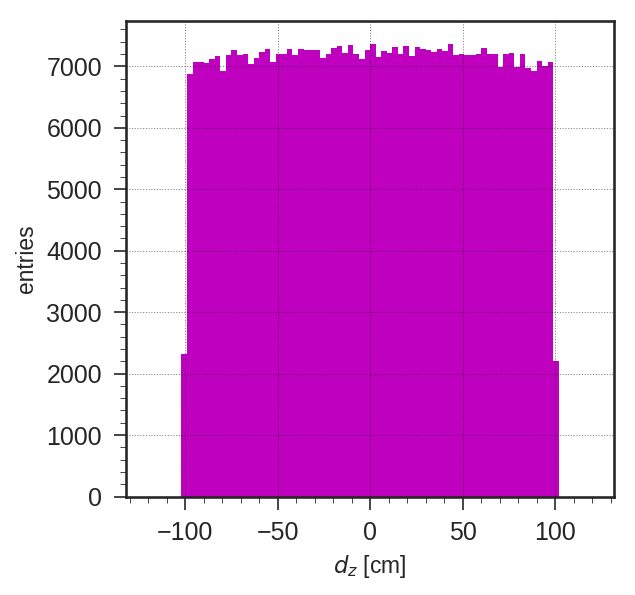

In [17]:
# Plot q/pT, d0, dz - displ

plt.figure()
plt.hist(y_test_displ/reg_pt_scale, bins=80, range=(-0.5,0.5), color='m')
plt.xlabel(r'$q/p_{T}$ [1/GeV]', fontsize=11)
plt.ylabel(r'entries', fontsize=11)

plt.figure()
plt.hist(dxy_test_displ/reg_dxy_scale, bins=80, range=(-120,120), color='m')
#plt.xlabel(r'$d_{xy}$ [cm]', fontsize=11)
plt.xlabel(r'$d_{0}$ [cm]', fontsize=11)
plt.ylabel(r'entries', fontsize=11)

plt.figure()
plt.hist(dz_test_displ, bins=80, range=(-120,120), color='m')
plt.xlabel(r'$d_{z}$ [cm]', fontsize=11)
plt.ylabel(r'entries', fontsize=11)

plt.show()

In [18]:
# Predictions

y_test_true = y_test.copy()
y_test_true /= reg_pt_scale

y_test_sel = (np.abs(1.0/y_test) >= 20./reg_pt_scale)

y_test_meas = model.predict(x_test, batch_size=4096)
y_test_meas /= reg_pt_scale
y_test_meas = y_test_meas.reshape(-1)

y_test_meas_check = model_displ.predict(x_test, batch_size=4096)
y_test_meas_check /= reg_pt_scale
y_test_meas_check = y_test_meas_check.reshape(-1)

y_test_true_displ = y_test_displ.copy()
y_test_true_displ /= reg_pt_scale

y_test_sel_displ = (np.abs(1.0/y_test_displ) >= 20./reg_pt_scale)

y_test_meas_displ = model_displ.predict(x_test_displ, batch_size=4096)
y_test_meas_displ /= reg_pt_scale
y_test_meas_displ = y_test_meas_displ.reshape(-1)

y_test_meas_check_displ = model.predict(x_test_displ, batch_size=4096)
y_test_meas_check_displ /= reg_pt_scale
y_test_meas_check_displ = y_test_meas_check_displ.reshape(-1)

In [19]:
print y_test_true.shape, y_test_meas.shape, y_test_meas_check.shape
print y_test_true_displ.shape, y_test_meas_displ.shape, y_test_meas_check_displ.shape

(478800,) (478800,) (478800,)
(478800,) (478800,) (478800,)


[INFO    ] # of entries: 51240, mean: -0.000976085371803, std: 0.0304407235235
[INFO    ] gaus fit (a, mu, sig): [ 6.90632948e+03 -2.02594614e-03  1.26120053e-02]


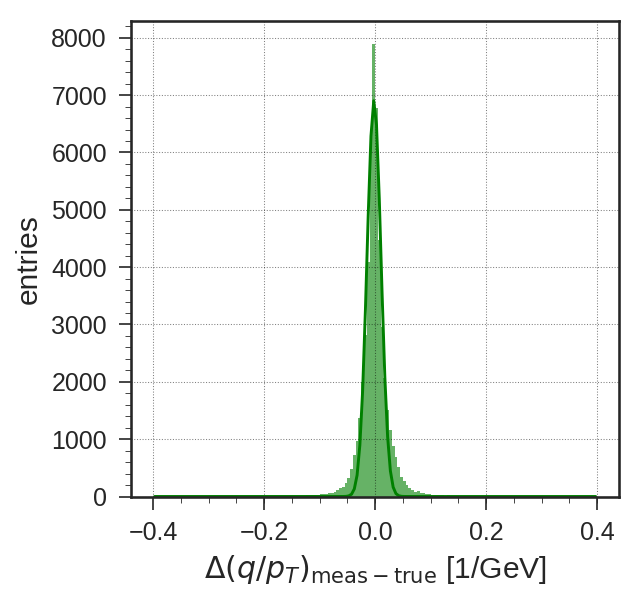

In [20]:
# Plot Delta(q/pT) - (a)

plt.figure()
yy = (y_test_meas - y_test_true)[y_test_sel]
hist, edges, _ = plt.hist(yy, bins=160, range=(-0.4,0.4-eps), histtype='stepfilled', facecolor='g', alpha=0.6)
plt.xlabel(r'$\Delta(q/p_{T})_{\mathrm{meas-true}}$ [1/GeV]')
plt.ylabel(r'entries')
logger.info('# of entries: {0}, mean: {1}, std: {2}'.format(len(yy), np.mean(yy), np.std(yy[np.abs(yy)<0.4])))

popt = fit_gaus(hist, edges, mu=np.mean(yy), sig=np.std(yy[np.abs(yy)<0.4]))
logger.info('gaus fit (a, mu, sig): {0}'.format(popt))
xdata = (edges[1:] + edges[:-1])/2
plt.plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='g')
plt.show()

[INFO    ] # of entries: 54454, mean: 0.00132994807791, std: 0.0765827968717
[INFO    ] gaus fit (a, mu, sig): [2.67848741e+03 3.07739161e-03 3.38920078e-02]


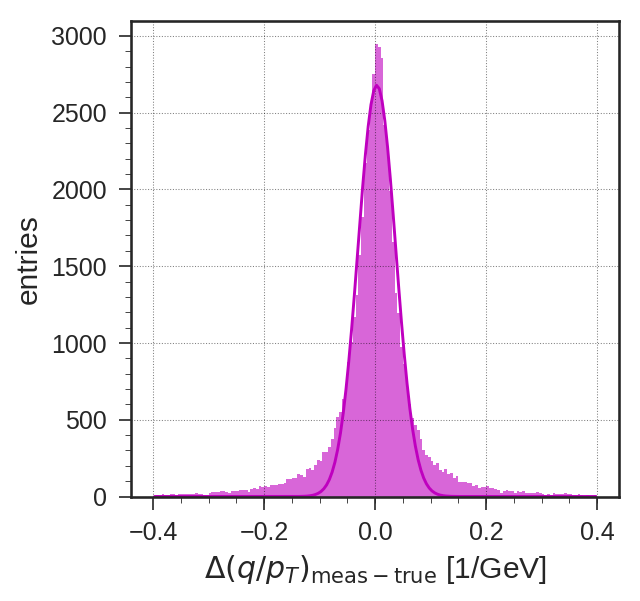

In [21]:
# Plot Delta(q/pT) - (b)

plt.figure()
yy = (y_test_meas_displ - y_test_true_displ)[y_test_sel_displ]
hist, edges, _ = plt.hist(yy, bins=160, range=(-0.4,0.4-eps), histtype='stepfilled', facecolor='m', alpha=0.6)
plt.xlabel(r'$\Delta(q/p_{T})_{\mathrm{meas-true}}$ [1/GeV]')
plt.ylabel(r'entries')
logger.info('# of entries: {0}, mean: {1}, std: {2}'.format(len(yy), np.mean(yy), np.std(yy[np.abs(yy)<0.4])))

popt = fit_gaus(hist, edges, mu=np.mean(yy), sig=np.std(yy[np.abs(yy)<0.4]))
logger.info('gaus fit (a, mu, sig): {0}'.format(popt))
xdata = (edges[1:] + edges[:-1])/2
plt.plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='m')
plt.show()

[INFO    ] # of entries: 51240, mean: -0.000103769780253, std: 0.0646022334695
[INFO    ] gaus fit (a, mu, sig): [2.75657827e+03 8.77512601e-04 3.24699676e-02]


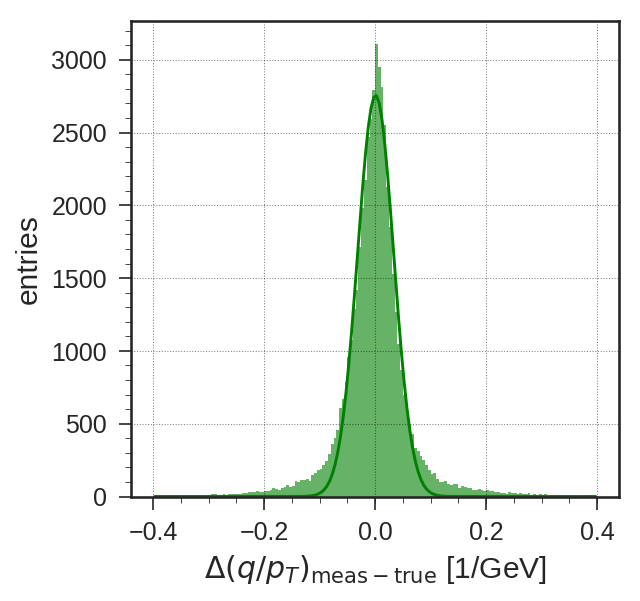

In [22]:
# Plot Delta(q/pT) - (c)

plt.figure()
yy = (y_test_meas_check - y_test_true)[y_test_sel]
hist, edges, _ = plt.hist(yy, bins=160, range=(-0.4,0.4-eps), histtype='stepfilled', facecolor='g', alpha=0.6)
plt.xlabel(r'$\Delta(q/p_{T})_{\mathrm{meas-true}}$ [1/GeV]')
plt.ylabel(r'entries')
logger.info('# of entries: {0}, mean: {1}, std: {2}'.format(len(yy), np.mean(yy), np.std(yy[np.abs(yy)<0.4])))

popt = fit_gaus(hist, edges, mu=np.mean(yy), sig=np.std(yy[np.abs(yy)<0.4]))
logger.info('gaus fit (a, mu, sig): {0}'.format(popt))
xdata = (edges[1:] + edges[:-1])/2
plt.plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='g')
plt.show()

[INFO    ] # of entries: 54454, mean: -0.000702172052115, std: 0.1728066504
[INFO    ] gaus fit (a, mu, sig): [5.47693708e+02 6.15367401e-04 1.83555373e-01]


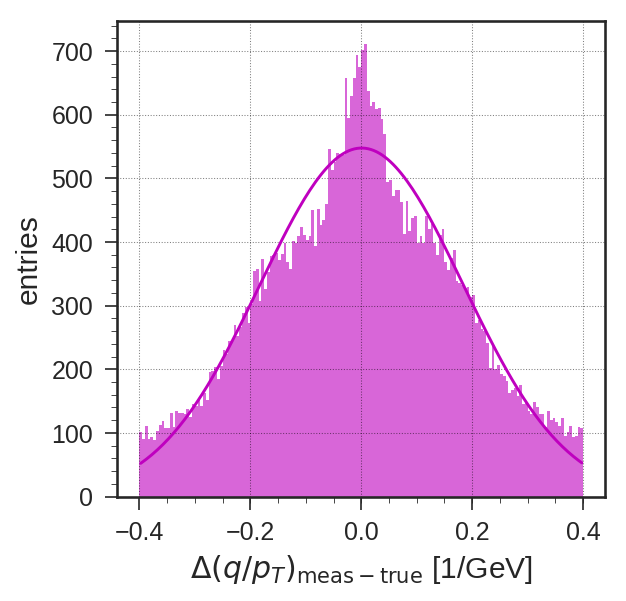

In [23]:
# Plot Delta(q/pT) - (d)

plt.figure()
yy = (y_test_meas_check_displ - y_test_true_displ)[y_test_sel_displ]
hist, edges, _ = plt.hist(yy, bins=160, range=(-0.4,0.4-eps), histtype='stepfilled', facecolor='m', alpha=0.6)
plt.xlabel(r'$\Delta(q/p_{T})_{\mathrm{meas-true}}$ [1/GeV]')
plt.ylabel(r'entries')
logger.info('# of entries: {0}, mean: {1}, std: {2}'.format(len(yy), np.mean(yy), np.std(yy[np.abs(yy)<0.4])))

popt = fit_gaus(hist, edges, mu=np.mean(yy), sig=np.std(yy[np.abs(yy)<0.4]))
logger.info('gaus fit (a, mu, sig): {0}'.format(popt))
xdata = (edges[1:] + edges[:-1])/2
plt.plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='m')
plt.show()

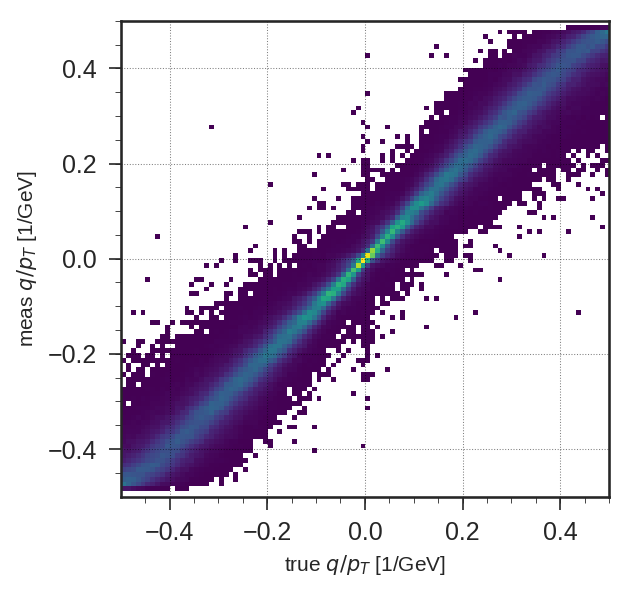

In [24]:
# Scatter plot - (a)

plt.figure()
plt.hist2d(y_test_true, y_test_meas, bins=(100,100), range=((-0.5,0.5),(-0.5,0.5)), vmin=1, cmap=my_cmap)
plt.xlabel(r'true $q/p_{T}$ [1/GeV]', fontsize=10)
plt.ylabel(r'meas $q/p_{T}$ [1/GeV]', fontsize=10)
plt.show()

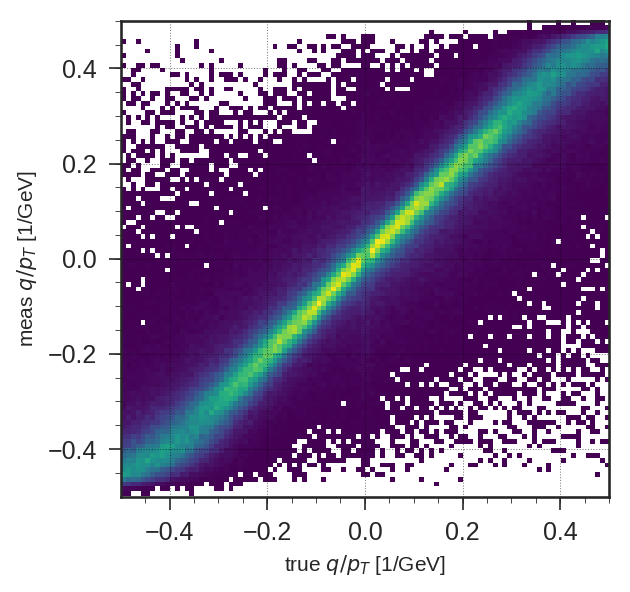

In [25]:
# Scatter plot - (b)

plt.figure()
plt.hist2d(y_test_true_displ, y_test_meas_displ, bins=(100,100), range=((-0.5,0.5),(-0.5,0.5)), vmin=1, cmap=my_cmap)
plt.xlabel(r'true $q/p_{T}$ [1/GeV]', fontsize=10)
plt.ylabel(r'meas $q/p_{T}$ [1/GeV]', fontsize=10)
plt.show()

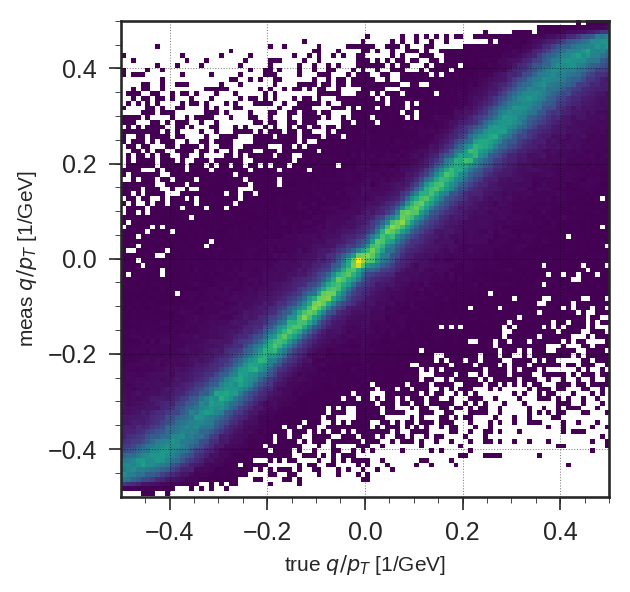

In [26]:
# Scatter plot - (c)

plt.figure()
plt.hist2d(y_test_true, y_test_meas_check, bins=(100,100), range=((-0.5,0.5),(-0.5,0.5)), vmin=1, cmap=my_cmap)
plt.xlabel(r'true $q/p_{T}$ [1/GeV]', fontsize=10)
plt.ylabel(r'meas $q/p_{T}$ [1/GeV]', fontsize=10)
plt.show()

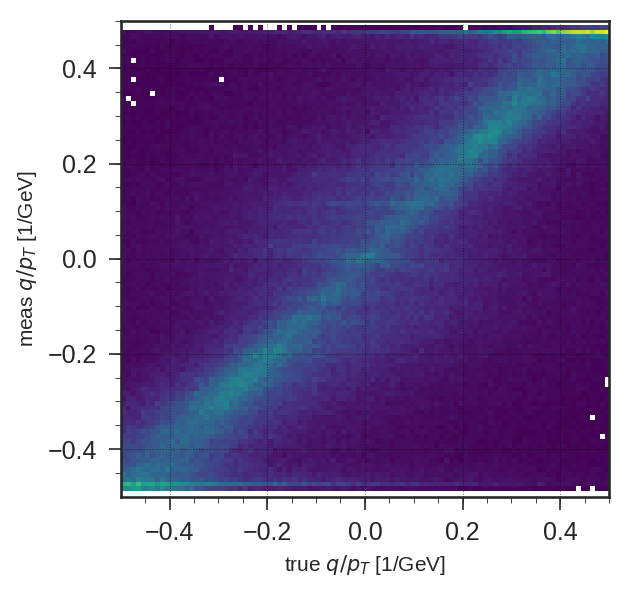

In [27]:
# Scatter plot - (d)

plt.figure()
plt.hist2d(y_test_true_displ, y_test_meas_check_displ, bins=(100,100), range=((-0.5,0.5),(-0.5,0.5)), vmin=1, cmap=my_cmap)
plt.xlabel(r'true $q/p_{T}$ [1/GeV]', fontsize=10)
plt.ylabel(r'meas $q/p_{T}$ [1/GeV]', fontsize=10)
plt.show()

### Training (Part II)

Try different cases:
- (a) Train with d0 only
- (b) Train with pT & d0, check pT & d0 resolution

In [28]:
model_d0 = create_model_sequential_bn2(nvariables=nvariables, lr=learning_rate, clipnorm=gradient_clip_norm, l1_reg=l1_reg, l2_reg=l2_reg,
                          nodes1=50, nodes2=40, nodes3=30, nodes4=20)

modelbestcheck = ModelCheckpoint(filepath='model_bchk.h5', monitor='val_loss', verbose=0, save_best_only=True)
modelbestcheck_weights = ModelCheckpoint(filepath='model_bchk_weights.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_11 (Batc (None, 36)                144       
_________________________________________________________________
dense_11 (Dense)             (None, 50)                1800      
_________________________________________________________________
batch_normalization_12 (Batc (None, 50)                200       
_________________________________________________________________
activation_9 (Activation)    (None, 50)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 40)                2000      
_________________________________________________________________
batch_normalization_13 (Batc (None, 40)                160       
_________________________________________________________________
activation_10 (Activation)   (None, 40)                0         
__________

In [29]:
logger.info('Begin training ...')
history = model_d0.fit(x_train_displ, dxy_train_displ/reg_dxy_scale,
                    epochs=epochs, batch_size=batch_size,
                    callbacks=[lr_decay,modelbestcheck,modelbestcheck_weights], validation_split=0.1, verbose=0)
logger.info('Done training.')
logger.info('Epoch {0}/{0} - loss: {1} - val_loss: {2}'.format(
    len(history.history['loss']), history.history['loss'][-1], history.history['val_loss'][-1]))

model_d0.load_weights('model_bchk_weights.h5')

[INFO    ] Begin training ...
[INFO    ] Done training.
[INFO    ] Epoch 300/300 - loss: 14.2620368001 - val_loss: 14.0758223114


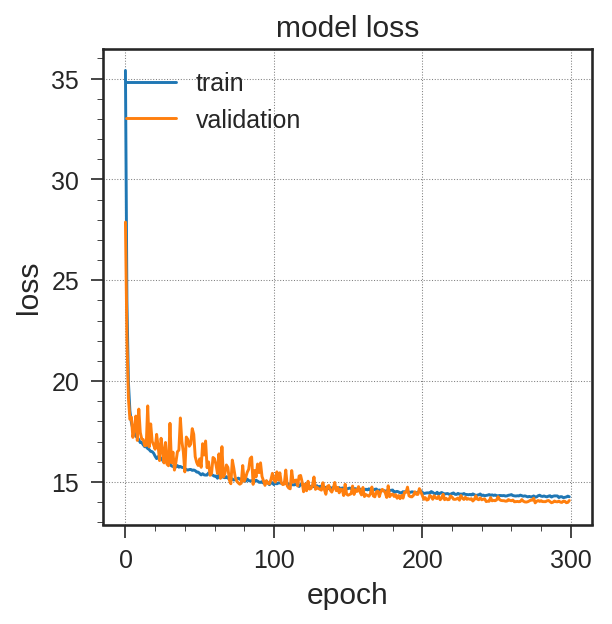

In [30]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [31]:
model_y_d0 = create_model_sequential_bn2(nvariables=nvariables, lr=learning_rate, clipnorm=gradient_clip_norm, l1_reg=l1_reg, l2_reg=l2_reg,
                          nodes1=50, nodes2=40, nodes3=30, nodes4=20, outnodes=2)

modelbestcheck = ModelCheckpoint(filepath='model_bchk.h5', monitor='val_loss', verbose=0, save_best_only=True)
modelbestcheck_weights = ModelCheckpoint(filepath='model_bchk_weights.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_16 (Batc (None, 36)                144       
_________________________________________________________________
dense_16 (Dense)             (None, 50)                1800      
_________________________________________________________________
batch_normalization_17 (Batc (None, 50)                200       
_________________________________________________________________
activation_13 (Activation)   (None, 50)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 40)                2000      
_________________________________________________________________
batch_normalization_18 (Batc (None, 40)                160       
_________________________________________________________________
activation_14 (Activation)   (None, 40)                0         
__________

In [32]:
logger.info('Begin training ...')
history = model_y_d0.fit(x_train_displ, np.column_stack((y_train_displ, dxy_train_displ)),
                    epochs=epochs, batch_size=batch_size,
                    callbacks=[lr_decay,modelbestcheck,modelbestcheck_weights], validation_split=0.1, verbose=0)
logger.info('Done training.')
logger.info('Epoch {0}/{0} - loss: {1} - val_loss: {2}'.format(
    len(history.history['loss']), history.history['loss'][-1], history.history['val_loss'][-1]))

model_y_d0.load_weights('model_bchk_weights.h5')

[INFO    ] Begin training ...
[INFO    ] Done training.
[INFO    ] Epoch 300/300 - loss: 5.94785688174 - val_loss: 5.70419186487


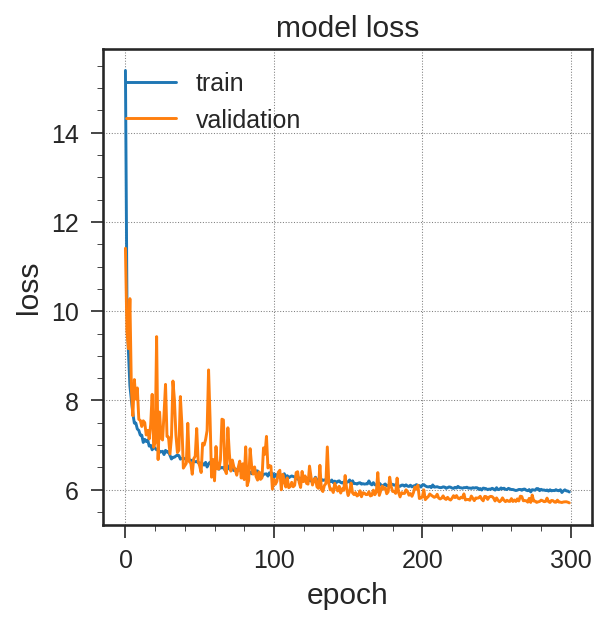

In [33]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [34]:
# Predictions

y_test_true = y_test_displ.copy()
y_test_true /= reg_pt_scale

y_test_sel = (np.abs(1.0/y_test_displ) >= 20./reg_pt_scale)

y_test_meas_ = model_y_d0.predict(x_test_displ, batch_size=4096)
y_test_meas = y_test_meas_[:,0]
y_test_meas /= reg_pt_scale
y_test_meas = y_test_meas.reshape(-1)

dxy_test_true = dxy_test_displ.copy()
dxy_test_true /= reg_dxy_scale

dxy_test_meas = y_test_meas_[:,1]
dxy_test_meas /= reg_dxy_scale
dxy_test_meas = dxy_test_meas.reshape(-1)

dxy_test_meas_check = model_d0.predict(x_test_displ, batch_size=4096)
#dxy_test_meas_check /= reg_dxy_scale
dxy_test_meas_check = dxy_test_meas_check.reshape(-1)

In [35]:
print y_test_true.shape, y_test_meas.shape, dxy_test_true.shape, dxy_test_meas.shape, dxy_test_meas_check.shape

(478800,) (478800,) (478800,) (478800,) (478800,)


[INFO    ] # of entries: 54454, mean: -0.385385990143, std: 10.7427177429
[INFO    ] gaus fit (a, mu, sig): [ 6.45834896e+03 -3.10484201e-01  5.97584960e+00]


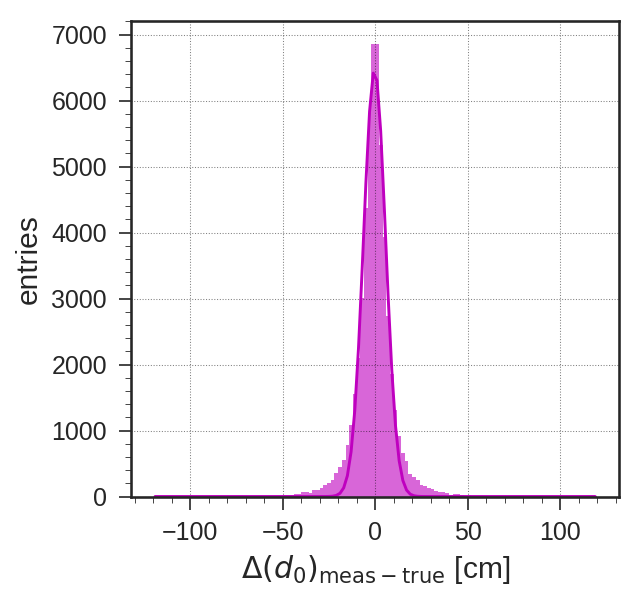

In [36]:
# Plot Delta(dxy) - (a)

plt.figure()
yy = (dxy_test_meas_check - dxy_test_true)[y_test_sel]
hist, edges, _ = plt.hist(yy, bins=120, range=(-120,120), histtype='stepfilled', facecolor='m', alpha=0.6)
#plt.xlabel(r'$\Delta(d_{xy})_{\mathrm{meas-true}}$ [cm]')
plt.xlabel(r'$\Delta(d_{0})_{\mathrm{meas-true}}$ [cm]')
plt.ylabel(r'entries')
logger.info('# of entries: {0}, mean: {1}, std: {2}'.format(len(yy), np.mean(yy), np.std(yy)))

popt = fit_gaus(hist, edges, mu=np.mean(yy), sig=np.std(yy))
logger.info('gaus fit (a, mu, sig): {0}'.format(popt))
xdata = (edges[1:] + edges[:-1])/2
plt.plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='m')
plt.show()

[INFO    ] # of entries: 54454, mean: -0.0445557832718, std: 11.1867351532
[INFO    ] gaus fit (a, mu, sig): [ 7.16251391e+03 -1.76046903e-01  5.24043198e+00]


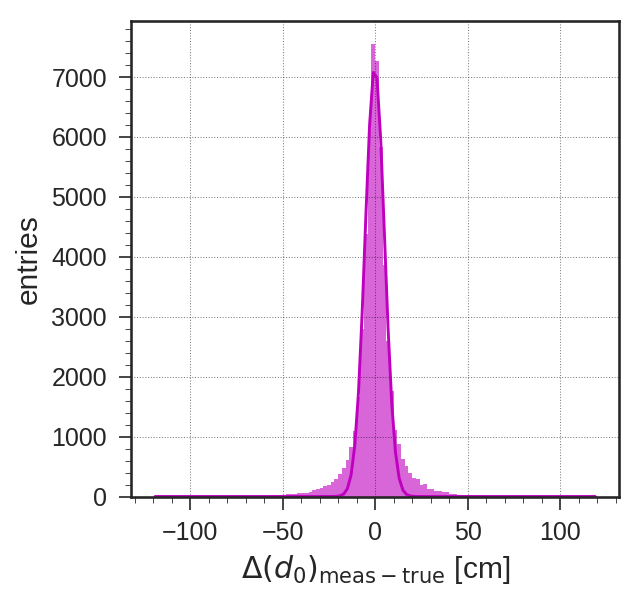

In [37]:
# Plot Delta(dxy) - (b)

plt.figure()
yy = (dxy_test_meas - dxy_test_true)[y_test_sel]
hist, edges, _ = plt.hist(yy, bins=120, range=(-120,120), histtype='stepfilled', facecolor='m', alpha=0.6)
#plt.xlabel(r'$\Delta(d_{xy})_{\mathrm{meas-true}}$ [cm]')
plt.xlabel(r'$\Delta(d_{0})_{\mathrm{meas-true}}$ [cm]')
plt.ylabel(r'entries')
logger.info('# of entries: {0}, mean: {1}, std: {2}'.format(len(yy), np.mean(yy), np.std(yy)))

popt = fit_gaus(hist, edges, mu=np.mean(yy), sig=np.std(yy))
logger.info('gaus fit (a, mu, sig): {0}'.format(popt))
xdata = (edges[1:] + edges[:-1])/2
plt.plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='m')
plt.show()

[INFO    ] # of entries: 54454, mean: -0.00193163158838, std: 0.0815492495894
[INFO    ] gaus fit (a, mu, sig): [ 2.44334613e+03 -3.53629330e-03  3.71150901e-02]


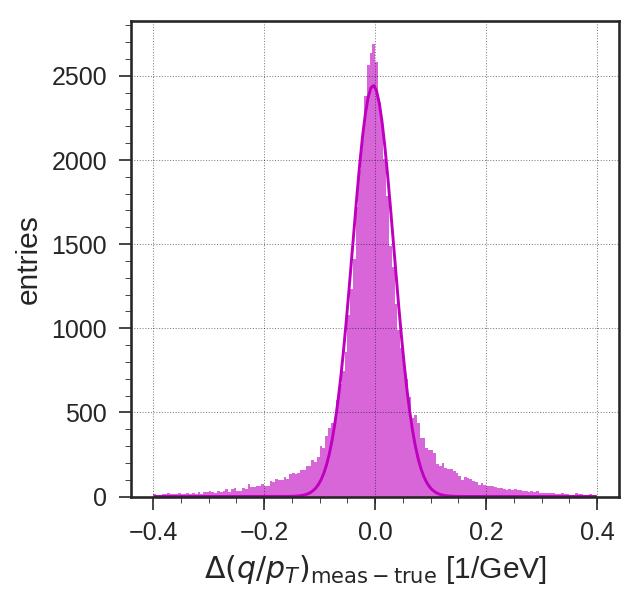

In [38]:
# Plot Delta(q/pT) - (b)

plt.figure()
yy = (y_test_meas - y_test_true)[y_test_sel]
hist, edges, _ = plt.hist(yy, bins=160, range=(-0.4,0.4-eps), histtype='stepfilled', facecolor='m', alpha=0.6)
plt.xlabel(r'$\Delta(q/p_{T})_{\mathrm{meas-true}}$ [1/GeV]')
plt.ylabel(r'entries')
logger.info('# of entries: {0}, mean: {1}, std: {2}'.format(len(yy), np.mean(yy), np.std(yy[np.abs(yy)<0.4])))

popt = fit_gaus(hist, edges, mu=np.mean(yy), sig=np.std(yy[np.abs(yy)<0.4]))
logger.info('gaus fit (a, mu, sig): {0}'.format(popt))
xdata = (edges[1:] + edges[:-1])/2
plt.plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='m')
plt.show()

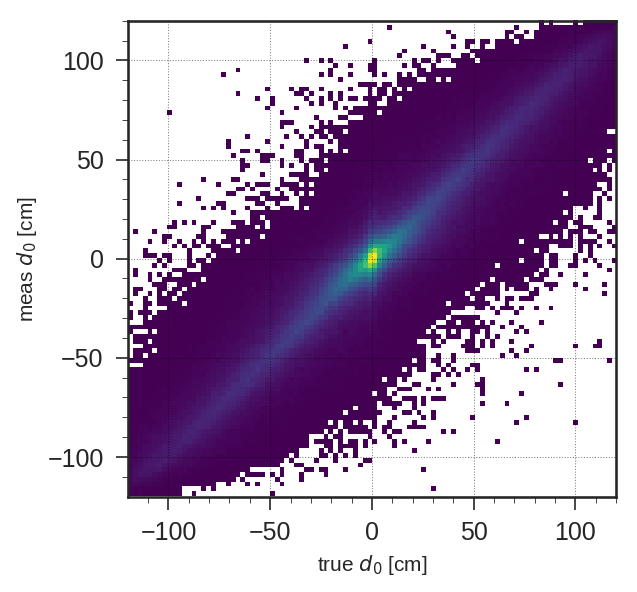

In [39]:
# Scatter plot - (a)

plt.figure()
plt.hist2d(dxy_test_true, dxy_test_meas_check, bins=(100,100), range=((-120,120),(-120,120)), vmin=1, cmap=my_cmap)
#plt.xlabel(r'true $d_{xy}$ [cm]', fontsize=10)
#plt.ylabel(r'meas $d_{xy}$ [cm]', fontsize=10)
plt.xlabel(r'true $d_{0}$ [cm]', fontsize=10)
plt.ylabel(r'meas $d_{0}$ [cm]', fontsize=10)
plt.show()

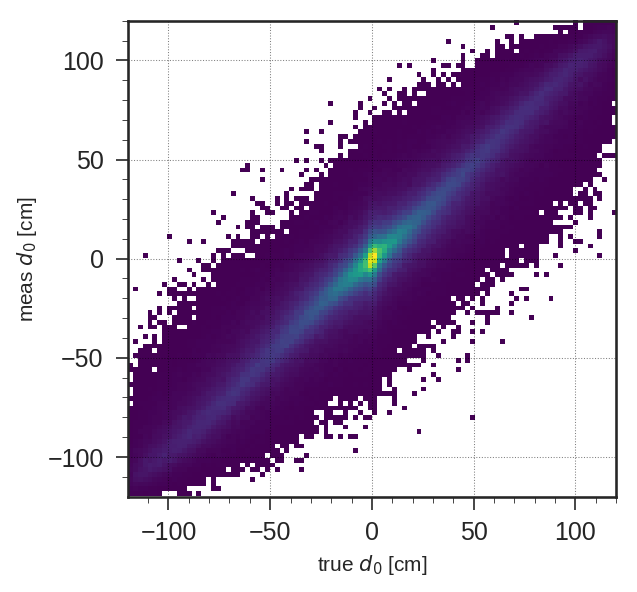

In [40]:
# Scatter plot - (b)

plt.figure()
plt.hist2d(dxy_test_true, dxy_test_meas, bins=(100,100), range=((-120,120),(-120,120)), vmin=1, cmap=my_cmap)
#plt.xlabel(r'true $d_{xy}$ [cm]', fontsize=10)
#plt.ylabel(r'meas $d_{xy}$ [cm]', fontsize=10)
plt.xlabel(r'true $d_{0}$ [cm]', fontsize=10)
plt.ylabel(r'meas $d_{0}$ [cm]', fontsize=10)
plt.show()

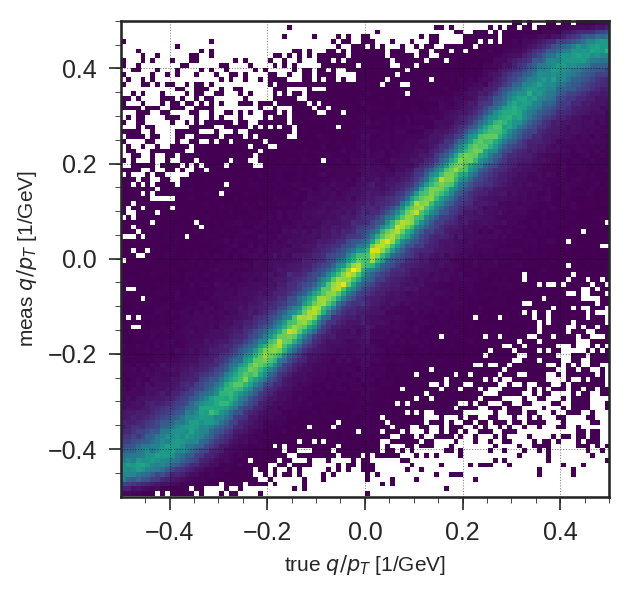

In [41]:
# Scatter plot - (b)

plt.figure()
plt.hist2d(y_test_true, y_test_meas, bins=(100,100), range=((-0.5,0.5),(-0.5,0.5)), vmin=1, cmap=my_cmap)
plt.xlabel(r'true $q/p_{T}$ [1/GeV]', fontsize=10)
plt.ylabel(r'meas $q/p_{T}$ [1/GeV]', fontsize=10)
plt.show()

### Training (Part III)

Try different cases:
- (a) Train with pT & d0, for reg_dxy_scale = 0.05
- (b) Train with pT & d0, for reg_dxy_scale = 0.1
- (c) Train with pT & d0, for reg_dxy_scale = 0.2
- (d) Train with pT & d0, for reg_dxy_scale = 0.5
- (e) Train with pT & d0, for reg_dxy_scale = 1.0
- (f) Train with pT & d0, for reg_dxy_scale = 5.0

In [42]:
def part3_training():
  model_y_d0_1 = create_model_sequential_bn2(nvariables=nvariables, lr=learning_rate, clipnorm=gradient_clip_norm, l1_reg=l1_reg, l2_reg=l2_reg,
                          nodes1=50, nodes2=40, nodes3=30, nodes4=20, outnodes=2)
  
  modelbestcheck = ModelCheckpoint(filepath='model_bchk.h5', monitor='val_loss', verbose=0, save_best_only=True)
  modelbestcheck_weights = ModelCheckpoint(filepath='model_bchk_weights.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True)

  logger.info('Begin training ...')
  history = model_y_d0_1.fit(x_train_displ, np.column_stack((y_train_displ, dxy_train_displ / reg_dxy_scale * reg_dxy_scale_1)),
                      epochs=epochs, batch_size=batch_size,
                      callbacks=[lr_decay,modelbestcheck,modelbestcheck_weights], validation_split=0.1, verbose=0)
  logger.info('Done training.')
  logger.info('Epoch {0}/{0} - loss: {1} - val_loss: {2}'.format(
      len(history.history['loss']), history.history['loss'][-1], history.history['val_loss'][-1]))
  
  model_y_d0_1.load_weights('model_bchk_weights.h5')

  plt.figure(figsize=(3,3))
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()
  
  # Predictions
  y_test_true = y_test_displ.copy()
  y_test_true /= reg_pt_scale
  
  y_test_sel = (np.abs(1.0/y_test_displ) >= 20./reg_pt_scale)

  y_test_meas_ = model_y_d0_1.predict(x_test_displ, batch_size=4096)
  y_test_meas = y_test_meas_[:,0]
  y_test_meas /= reg_pt_scale
  y_test_meas = y_test_meas.reshape(-1)

  dxy_test_true = dxy_test_displ.copy()
  dxy_test_true /= reg_dxy_scale

  dxy_test_meas = y_test_meas_[:,1]
  dxy_test_meas /= reg_dxy_scale_1
  dxy_test_meas = dxy_test_meas.reshape(-1)
  
  # Plot
  plt.figure(figsize=(3,3))
  yy = (dxy_test_meas - dxy_test_true)[y_test_sel]
  hist, edges, _ = plt.hist(yy, bins=120, range=(-120,120), histtype='stepfilled', facecolor='m', alpha=0.6)
  #plt.xlabel(r'$\Delta(d_{xy})_{\mathrm{meas-true}}$ [cm]')
  plt.xlabel(r'$\Delta(d_{0})_{\mathrm{meas-true}}$ [cm]')
  plt.ylabel(r'entries')
  logger.info('# of entries: {0}, mean: {1}, std: {2}'.format(len(yy), np.mean(yy), np.std(yy)))

  popt = fit_gaus(hist, edges, mu=np.mean(yy), sig=np.std(yy))
  logger.info('gaus fit (a, mu, sig): {0}'.format(popt))
  xdata = (edges[1:] + edges[:-1])/2
  plt.plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='m')

  plt.figure(figsize=(3,3))
  yy = (y_test_meas - y_test_true)[y_test_sel]
  hist, edges, _ = plt.hist(yy, bins=160, range=(-0.4,0.4-eps), histtype='stepfilled', facecolor='m', alpha=0.6)
  plt.xlabel(r'$\Delta(q/p_{T})_{\mathrm{meas-true}}$ [1/GeV]')
  plt.ylabel(r'entries')
  logger.info('# of entries: {0}, mean: {1}, std: {2}'.format(len(yy), np.mean(yy), np.std(yy[np.abs(yy)<0.4])))

  popt = fit_gaus(hist, edges, mu=np.mean(yy), sig=np.std(yy[np.abs(yy)<0.4]))
  logger.info('gaus fit (a, mu, sig): {0}'.format(popt))
  xdata = (edges[1:] + edges[:-1])/2
  plt.plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='m')

  plt.figure(figsize=(3,3))
  plt.hist2d(dxy_test_true, dxy_test_meas, bins=(100,100), range=((-120,120),(-120,120)), vmin=1, cmap=my_cmap)
  #plt.xlabel(r'true $d_{xy}$ [cm]', fontsize=10)
  #plt.ylabel(r'meas $d_{xy}$ [cm]', fontsize=10)
  plt.xlabel(r'true $d_{0}$ [cm]', fontsize=10)
  plt.ylabel(r'meas $d_{0}$ [cm]', fontsize=10)
  plt.show()

  plt.figure(figsize=(3,3))
  plt.hist2d(y_test_true, y_test_meas, bins=(100,100), range=((-0.5,0.5),(-0.5,0.5)), vmin=1, cmap=my_cmap)
  plt.xlabel(r'true $q/p_{T}$ [1/GeV]', fontsize=10)
  plt.ylabel(r'meas $q/p_{T}$ [1/GeV]', fontsize=10)
  plt.show()

  plt.show()

[INFO    ] Begin training ...


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_21 (Batc (None, 36)                144       
_________________________________________________________________
dense_21 (Dense)             (None, 50)                1800      
_________________________________________________________________
batch_normalization_22 (Batc (None, 50)                200       
_________________________________________________________________
activation_17 (Activation)   (None, 50)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 40)                2000      
_________________________________________________________________
batch_normalization_23 (Batc (None, 40)                160       
_________________________________________________________________
activation_18 (Activation)   (None, 40)                0         
__________

[INFO    ] Done training.
[INFO    ] Epoch 300/300 - loss: 3.4664328053 - val_loss: 3.29361338097


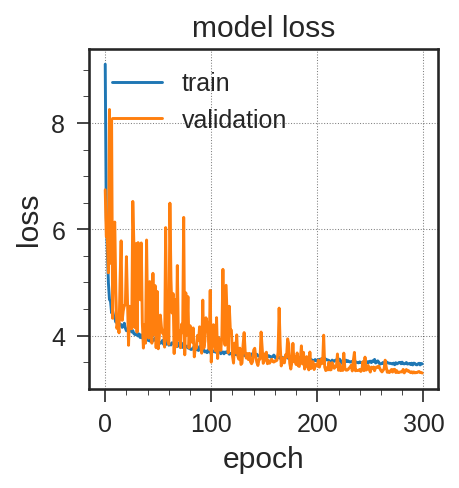

[INFO    ] # of entries: 54454, mean: 0.824008524418, std: 13.4802913666
[INFO    ] gaus fit (a, mu, sig): [5.27408515e+03 9.35602601e-01 7.22423484e+00]
[INFO    ] # of entries: 54454, mean: -0.00518503133208, std: 0.0809040740132
[INFO    ] gaus fit (a, mu, sig): [ 2.39753962e+03 -6.67231782e-03  3.81350536e-02]


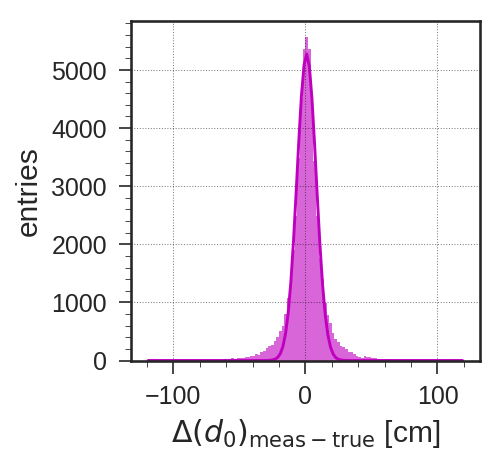

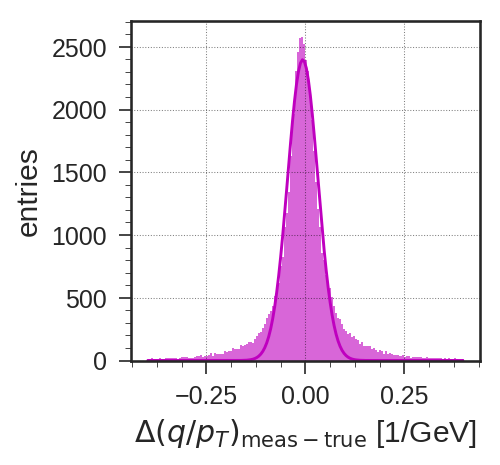

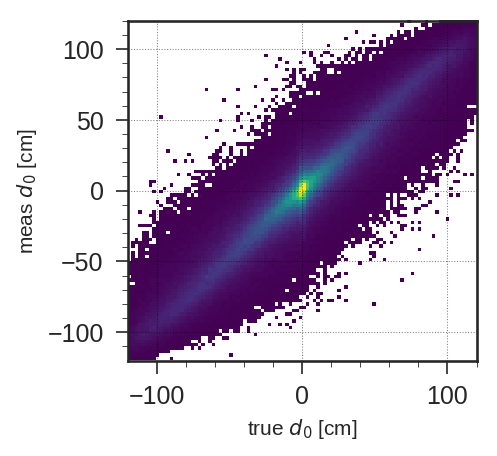

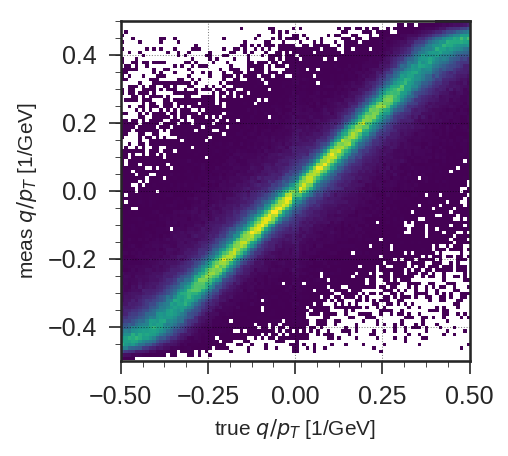

In [43]:
reg_dxy_scale_1 = 0.05

part3_training()

[INFO    ] Begin training ...


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_26 (Batc (None, 36)                144       
_________________________________________________________________
dense_26 (Dense)             (None, 50)                1800      
_________________________________________________________________
batch_normalization_27 (Batc (None, 50)                200       
_________________________________________________________________
activation_21 (Activation)   (None, 50)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 40)                2000      
_________________________________________________________________
batch_normalization_28 (Batc (None, 40)                160       
_________________________________________________________________
activation_22 (Activation)   (None, 40)                0         
__________

[INFO    ] Done training.
[INFO    ] Epoch 300/300 - loss: 3.68373439215 - val_loss: 3.52061959267


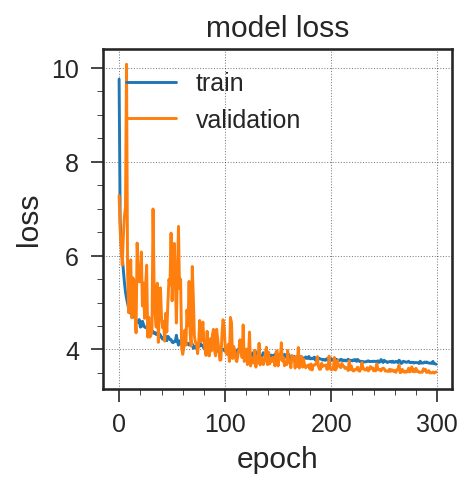

[INFO    ] # of entries: 54454, mean: -0.0907113477588, std: 11.3607902527
[INFO    ] gaus fit (a, mu, sig): [ 6.79248160e+03 -2.02731286e-02  5.60790717e+00]
[INFO    ] # of entries: 54454, mean: 0.00102942623198, std: 0.0769533365965
[INFO    ] gaus fit (a, mu, sig): [2.65750019e+03 3.47995152e-04 3.39758510e-02]


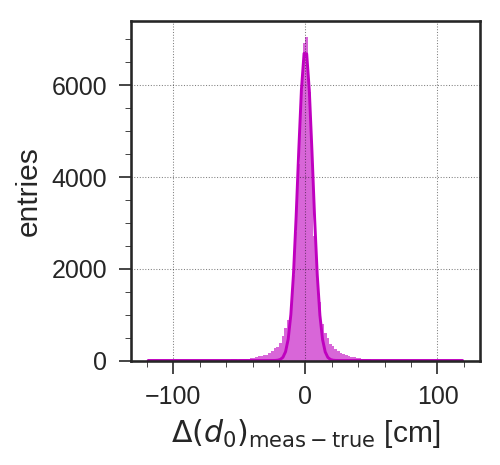

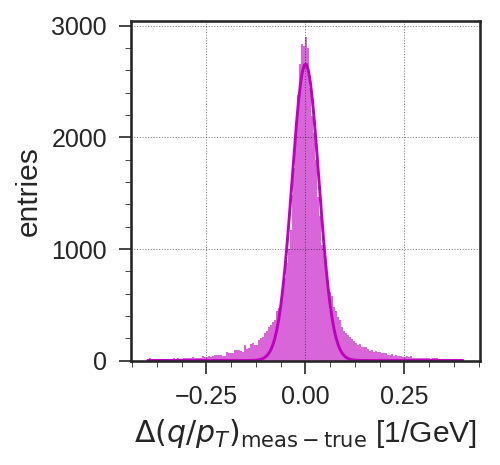

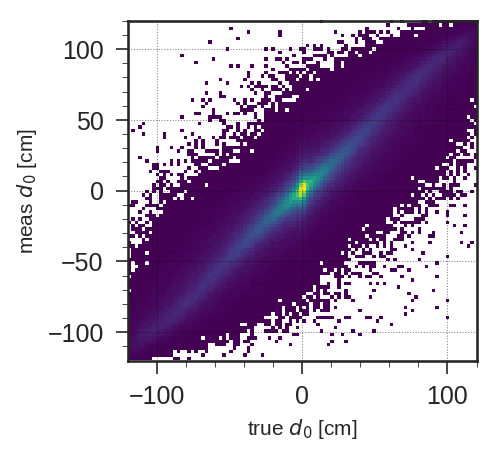

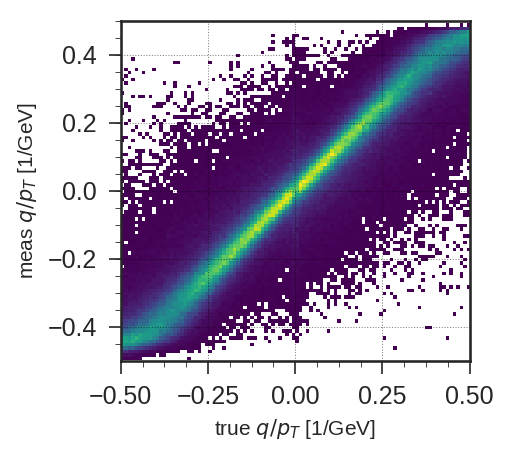

In [44]:
reg_dxy_scale_1 = 0.1

part3_training()

[INFO    ] Begin training ...


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_31 (Batc (None, 36)                144       
_________________________________________________________________
dense_31 (Dense)             (None, 50)                1800      
_________________________________________________________________
batch_normalization_32 (Batc (None, 50)                200       
_________________________________________________________________
activation_25 (Activation)   (None, 50)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 40)                2000      
_________________________________________________________________
batch_normalization_33 (Batc (None, 40)                160       
_________________________________________________________________
activation_26 (Activation)   (None, 40)                0         
__________

[INFO    ] Done training.
[INFO    ] Epoch 300/300 - loss: 4.49282720978 - val_loss: 4.26698725551


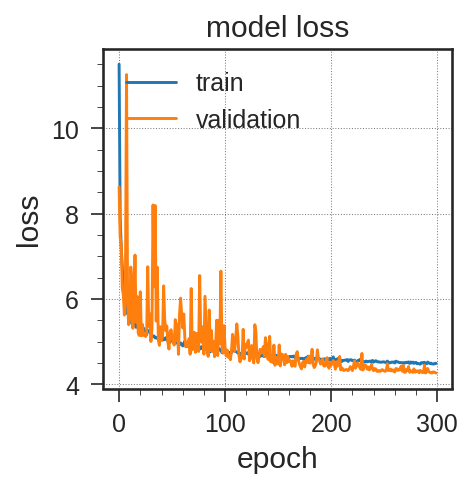

[INFO    ] # of entries: 54454, mean: 0.348320007324, std: 12.2143373489
[INFO    ] gaus fit (a, mu, sig): [6.63222842e+03 2.26367130e-01 5.58943869e+00]
[INFO    ] # of entries: 54454, mean: -0.00131514377426, std: 0.0813253745437
[INFO    ] gaus fit (a, mu, sig): [ 2.43920308e+03 -1.31512175e-03  3.71496295e-02]


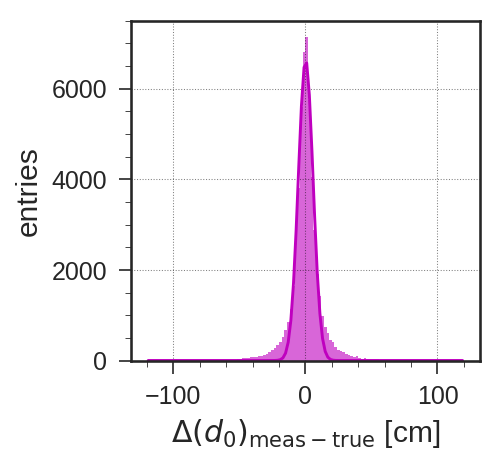

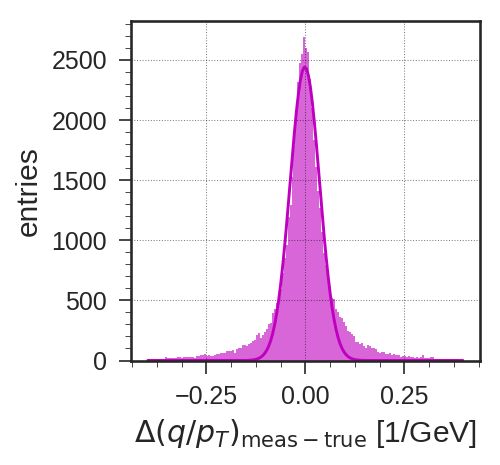

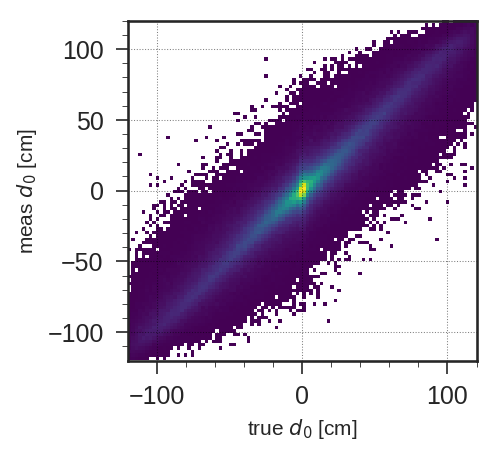

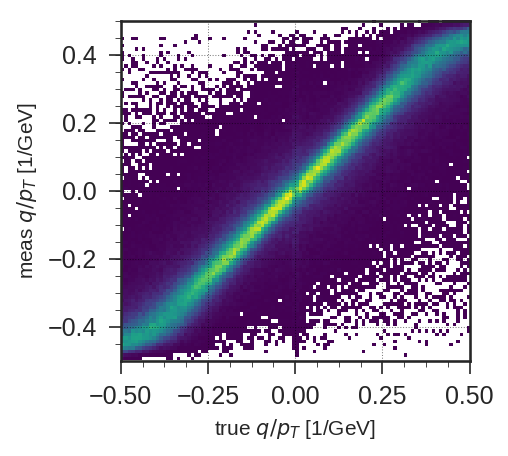

In [45]:
reg_dxy_scale_1 = 0.2

part3_training()

[INFO    ] Begin training ...


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_36 (Batc (None, 36)                144       
_________________________________________________________________
dense_36 (Dense)             (None, 50)                1800      
_________________________________________________________________
batch_normalization_37 (Batc (None, 50)                200       
_________________________________________________________________
activation_29 (Activation)   (None, 50)                0         
_________________________________________________________________
dense_37 (Dense)             (None, 40)                2000      
_________________________________________________________________
batch_normalization_38 (Batc (None, 40)                160       
_________________________________________________________________
activation_30 (Activation)   (None, 40)                0         
__________

[INFO    ] Done training.
[INFO    ] Epoch 300/300 - loss: 6.59371295436 - val_loss: 6.25844440764


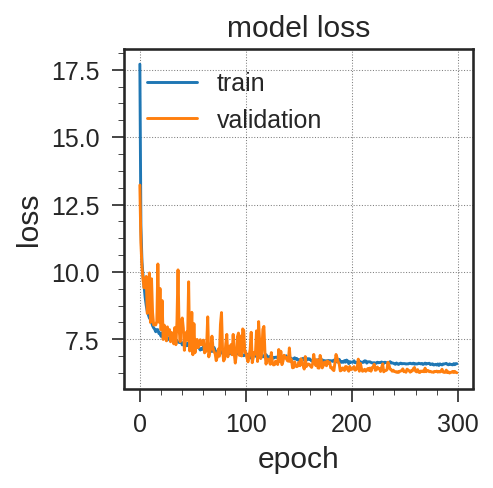

[INFO    ] # of entries: 54454, mean: 0.0165149010718, std: 9.93886470795
[INFO    ] gaus fit (a, mu, sig): [ 8.39866174e+03 -2.74931736e-02  4.49099111e+00]
[INFO    ] # of entries: 54454, mean: -0.000727077480406, std: 0.0789436399937
[INFO    ] gaus fit (a, mu, sig): [2.58263393e+03 8.24121972e-05 3.49831648e-02]


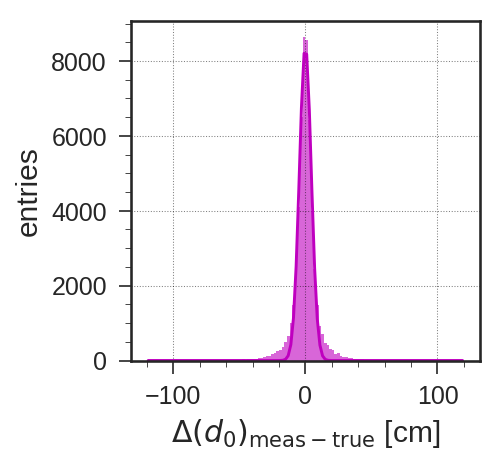

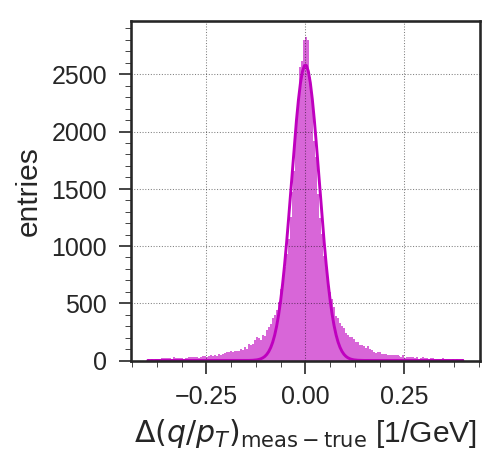

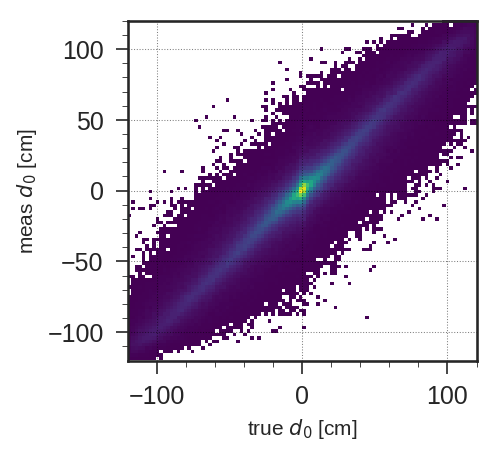

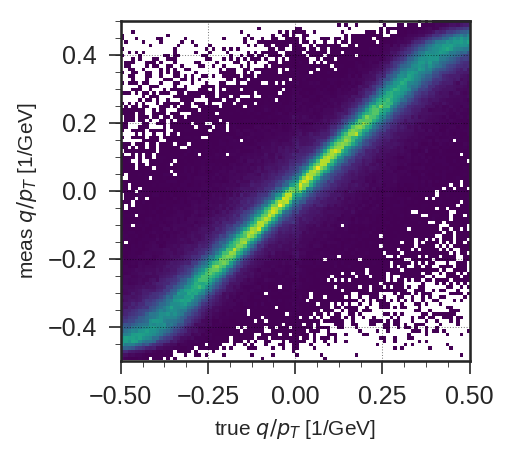

In [46]:
reg_dxy_scale_1 = 0.5

part3_training()

[INFO    ] Begin training ...


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_41 (Batc (None, 36)                144       
_________________________________________________________________
dense_41 (Dense)             (None, 50)                1800      
_________________________________________________________________
batch_normalization_42 (Batc (None, 50)                200       
_________________________________________________________________
activation_33 (Activation)   (None, 50)                0         
_________________________________________________________________
dense_42 (Dense)             (None, 40)                2000      
_________________________________________________________________
batch_normalization_43 (Batc (None, 40)                160       
_________________________________________________________________
activation_34 (Activation)   (None, 40)                0         
__________

[INFO    ] Done training.
[INFO    ] Epoch 300/300 - loss: 10.5305994079 - val_loss: 10.2326761684


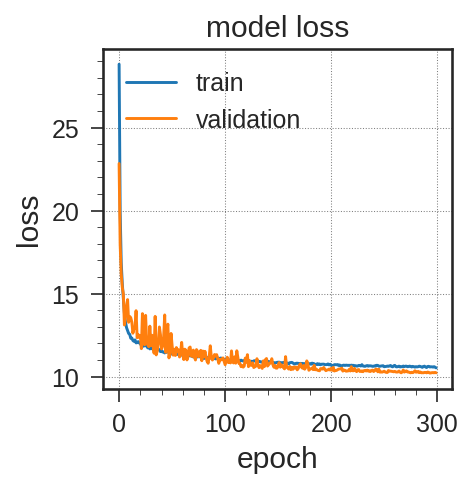

[INFO    ] # of entries: 54454, mean: 0.108271285892, std: 10.952205658
[INFO    ] gaus fit (a, mu, sig): [7.19783224e+03 2.10045254e-01 5.24532841e+00]
[INFO    ] # of entries: 54454, mean: -0.00146344304085, std: 0.0843970254064
[INFO    ] gaus fit (a, mu, sig): [ 2.38766926e+03 -2.43074415e-03  3.77622512e-02]


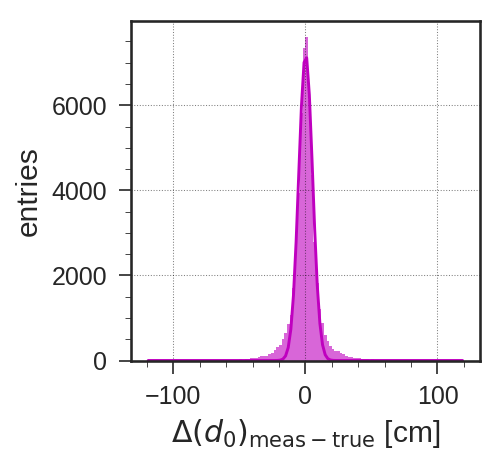

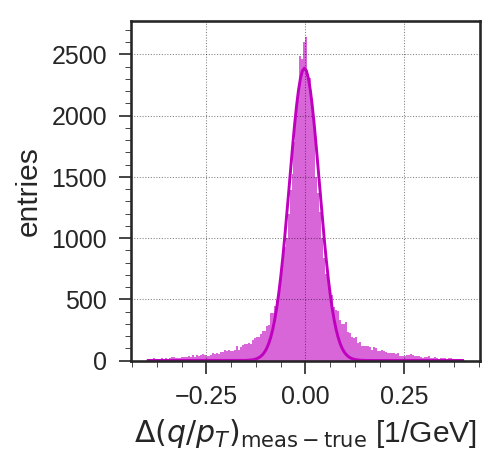

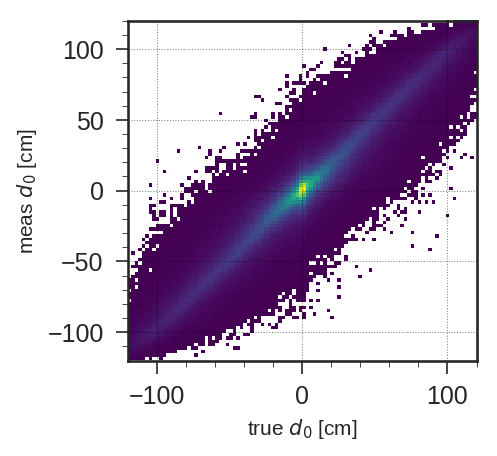

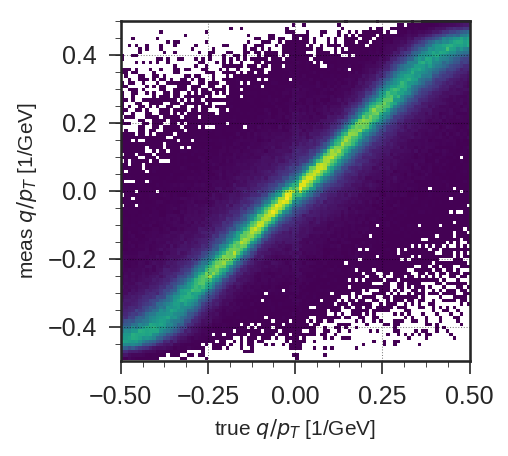

In [47]:
reg_dxy_scale_1 = 1.0

part3_training()

[INFO    ] Begin training ...


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_46 (Batc (None, 36)                144       
_________________________________________________________________
dense_46 (Dense)             (None, 50)                1800      
_________________________________________________________________
batch_normalization_47 (Batc (None, 50)                200       
_________________________________________________________________
activation_37 (Activation)   (None, 50)                0         
_________________________________________________________________
dense_47 (Dense)             (None, 40)                2000      
_________________________________________________________________
batch_normalization_48 (Batc (None, 40)                160       
_________________________________________________________________
activation_38 (Activation)   (None, 40)                0         
__________

[INFO    ] Done training.
[INFO    ] Epoch 300/300 - loss: 39.8746988545 - val_loss: 38.8520867473


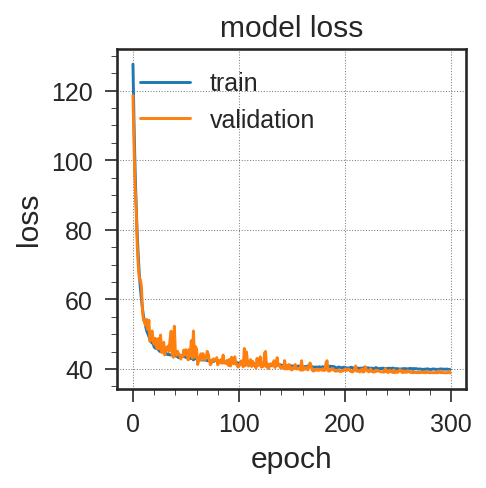

[INFO    ] # of entries: 54454, mean: 0.218937665224, std: 10.1525707245
[INFO    ] gaus fit (a, mu, sig): [7.83204932e+03 2.54017057e-01 4.83043017e+00]
[INFO    ] # of entries: 54454, mean: -0.000822272442747, std: 0.0877473130822
[INFO    ] gaus fit (a, mu, sig): [ 2.23276267e+03 -3.12529436e-03  4.04553796e-02]


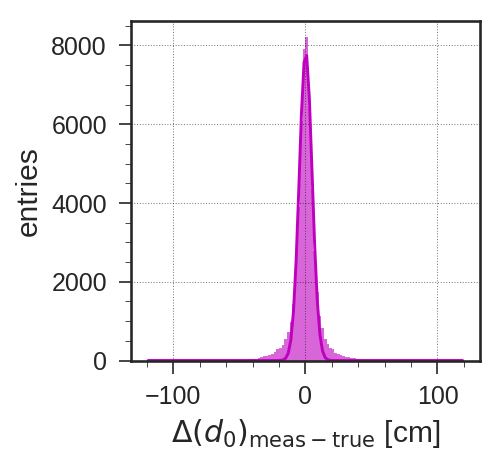

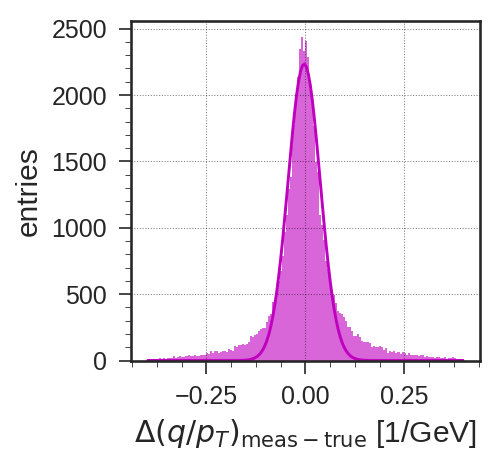

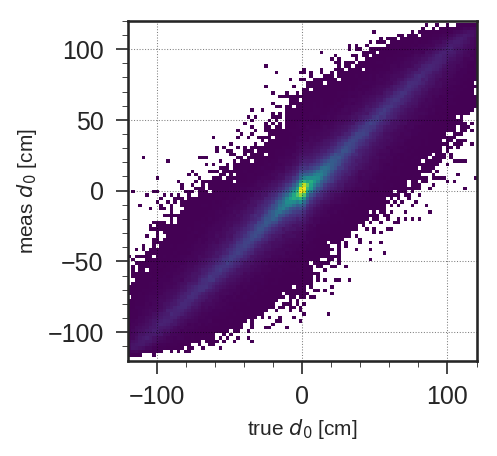

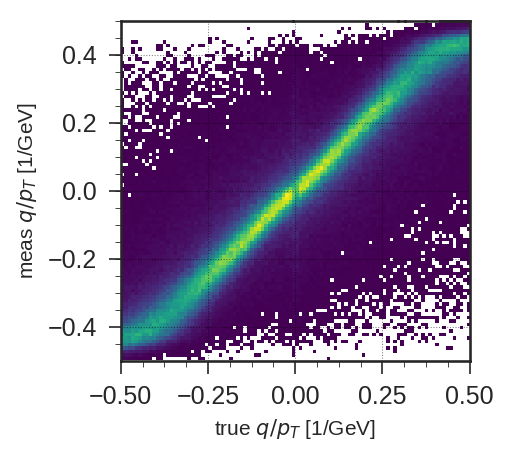

In [48]:
reg_dxy_scale_1 = 5.0

part3_training()